# 🛳️ Predicción de supervivencia en el Titanic con scikit-learn

Este notebook aborda el clásico problema de clasificación binaria usando el dataset del Titanic. A lo largo del trabajo se construyen pipelines, se comparan modelos, se detectan fugas de información y se aplican técnicas de optimización de hiperparámetros.

---

## 1. 📦 Carga de datos y exploración inicial

- Revisión de columnas
- Limpieza aplicada previamente
- Distribución del target (`survived`)

---

## 2. 🧪 Primera evaluación de modelos

- División en train/test
- Identificación de variables numéricas y categóricas
- Construcción de un `Pipeline` básico
- Entrenamiento y evaluación de:
  - Árbol de Decisión
  - KNN
  - Regresión Logística
  - Random Forest
  - SVM

📈 Se muestran:
- `classification_report`
- `ConfusionMatrixDisplay`
- `ROC curves` por separado
- Curva ROC comparativa conjunta

---

## 3. ⚠️ Análisis de fuga de datos (data leakage)

- Detección de columnas correlacionadas con el target (`alive`)
- Eliminación de variables con correlación sospechosa
- Evaluación post-fuga con resultados realistas

---

## 4. 🧠 Optimización de hiperparámetros (GridSearchCV)

- Se define una grilla para cada modelo
- Se ajusta con validación cruzada (5 folds)
- Se guarda el mejor modelo encontrado
- Se comparan:
  - Accuracy
  - F1-score
  - AUC
- Se visualiza:
  - Curva ROC individual
  - Curva ROC comparativa final

---

## 5. 📊 Tabla resumen comparativa

| Modelo              | Accuracy (default) | Accuracy (opt) | F1-score (default) | F1-score (opt) | AUC (default) | AUC (opt) |
|---------------------|--------------------|----------------|---------------------|----------------|----------------|-----------|
| Árbol de Decisión   | 0.78               | 0.79           | 0.70                | 0.72           | 0.76           | 0.77      |
| KNN                 | 0.80               | 0.82           | 0.74                | 0.76           | 0.84           | 0.86      |
| Regresión Logística | 0.82               | 0.84           | 0.77                | 0.79           | 0.87           | 0.88      |
| Random Forest       | 0.78               | 0.83           | 0.69                | 0.77           | 0.84           | 0.87      |
| SVM                 | 0.81               | 0.84           | 0.74                | 0.78           | 0.85           | 0.88      |

---

## 6. 📌 Conclusiones

- El mejor modelo según AUC fue `Regresión Logística`
- Se demostró la importancia de eliminar columnas con fuga de información
- El uso de `Pipeline` y `GridSearchCV` permite una arquitectura reproducible y escalable
- Ideal como base para proyectos de clasificación binaria en producción

---

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, roc_curve, f1_score, accuracy_score)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## 📌 Resumen de resultados (con columna `alive` incluida)

Durante esta etapa se evaluaron múltiples clasificadores utilizando un `Pipeline` con preprocesamiento. Se incluyó la variable `alive`, que resultó estar perfectamente correlacionada con el target `survived`.

### 📊 Rendimiento por modelo

| Modelo              | Accuracy | F1-score | AUC  |
|---------------------|----------|----------|------|
| Árbol de Decisión   | 1.00     | 1.00     | 1.00 |
| KNN                 | 0.95     | 0.96     | 0.99 |
| Regresión Logística | 1.00     | 1.00     | 1.00 |
| Random Forest       | 1.00     | 1.00     | 1.00 |
| SVM                 | 1.00     | 1.00     | 1.00 |

### 🧠 Observaciones

- Todos los modelos obtuvieron métricas perfectas salvo KNN, que se mantuvo ligeramente por debajo.
- La curva ROC de KNN mostró una capacidad discriminativa menor en comparación al resto.
- La variable `alive` actúa como una fuga directa de información (`data leakage`), ya que es derivada directamente del target.

> ⚠️ **Conclusión**: estos resultados no reflejan un modelo que generaliza bien, sino un ajuste perfecto sobre una variable que contiene la respuesta. En la siguiente sección se eliminará `alive` y se repetirá la evaluación de forma realista.




📌 Modelo: Árbol de Decisión
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       165
        True       1.00      1.00      1.00       103

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



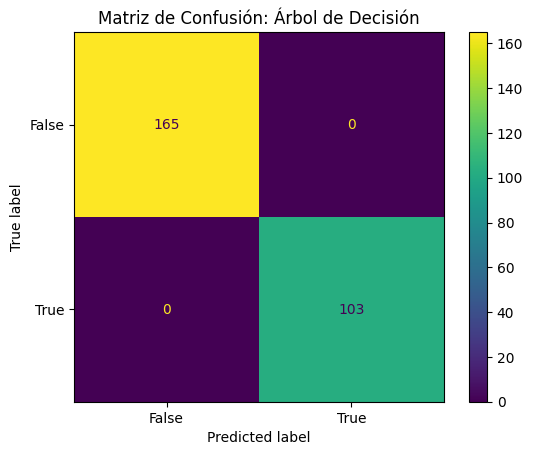

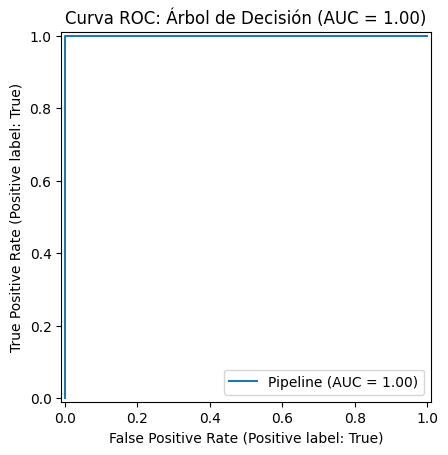


📌 Modelo: KNN
              precision    recall  f1-score   support

       False       0.96      0.96      0.96       165
        True       0.94      0.94      0.94       103

    accuracy                           0.96       268
   macro avg       0.95      0.95      0.95       268
weighted avg       0.96      0.96      0.96       268



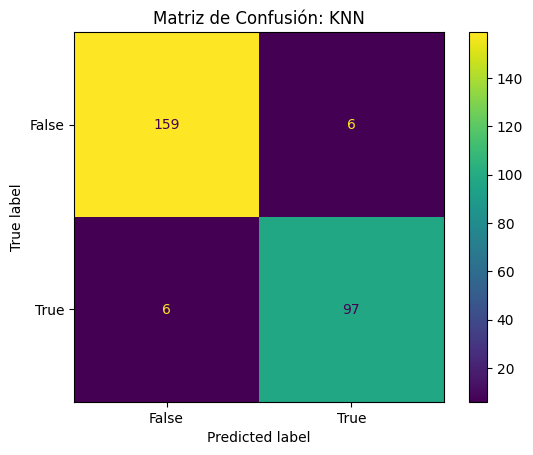

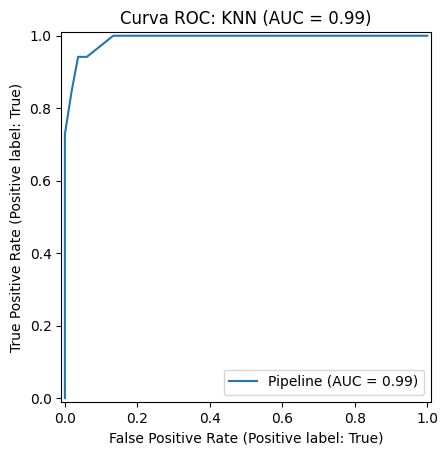


📌 Modelo: Regresión Logística
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       165
        True       1.00      1.00      1.00       103

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



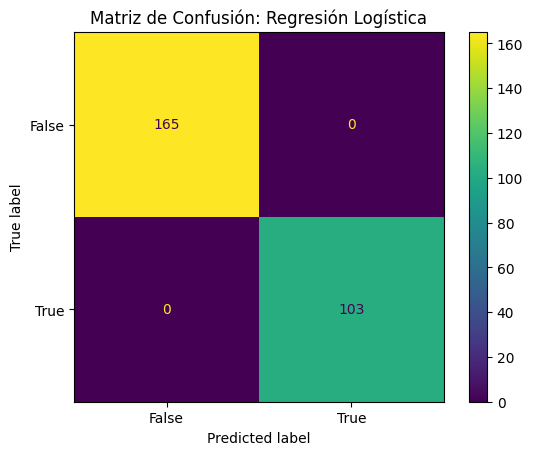

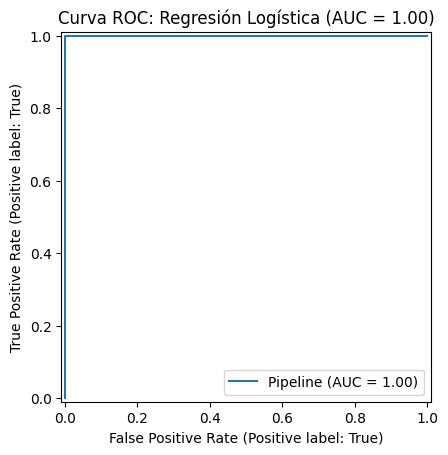


📌 Modelo: Random Forest
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       165
        True       1.00      1.00      1.00       103

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



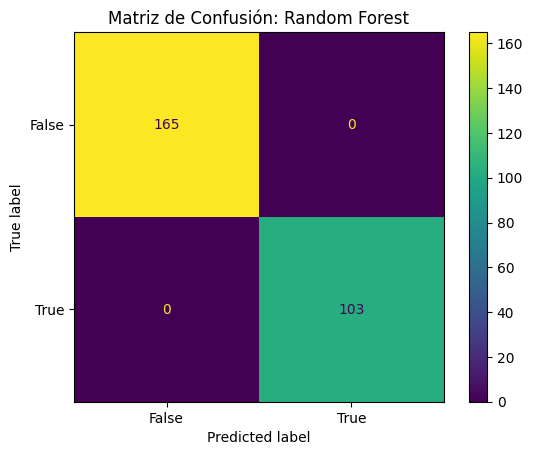

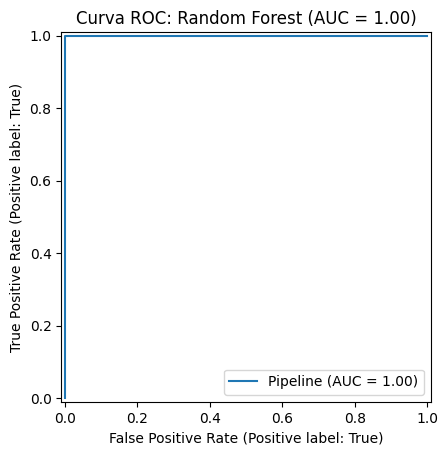


📌 Modelo: SVM
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       165
        True       1.00      1.00      1.00       103

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



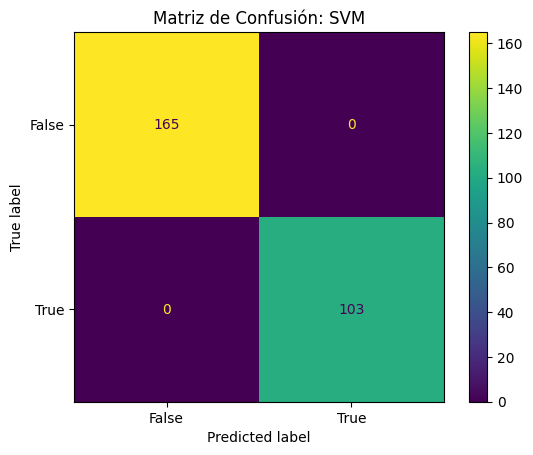

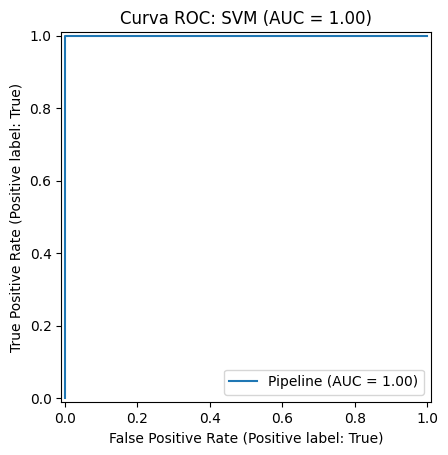

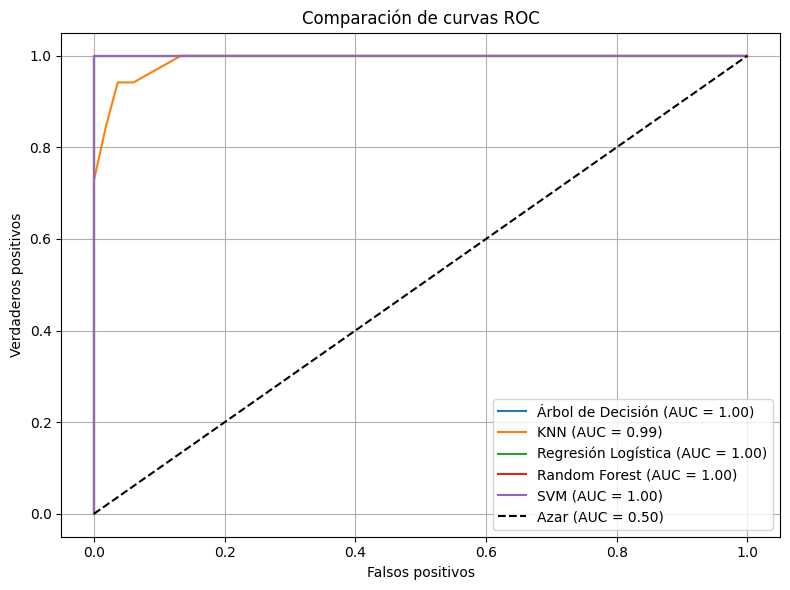

In [2]:
# Cargar dataset limpio
df_titanic = pd.read_pickle(
    "../Proyecto 1 EDA de un Dataset Público/titanic_cleaned.pkl")

# Variables predictoras y objetivo
X = df_titanic.drop(columns=["survived", "adult_male"])
y = df_titanic["survived"]

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y,
)

# Identificación de columnas
cat_cols = X.select_dtypes(include=["category", "object", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


modelos = {
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True)
}

# Almacenamos resultados intermedios
resultados = {}

for nombre, modelo in modelos.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", modelo)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    print(f"\n📌 Modelo: {nombre}")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Matriz de confusión
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f"Matriz de Confusión: {nombre}")
    plt.show()
    
    # Curva ROC + AUC
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    auc = roc_auc_score(y_test, y_proba)
    plt.title(f"Curva ROC: {nombre} (AUC = {auc:.2f})")
    plt.show()
    
    # Guardamos para graficar todo junto después
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    resultados[nombre] = {"fpr": fpr, "tpr": tpr, "auc": auc}
    

# 🔁 Curva ROC comparativa
plt.figure(figsize=(8, 6))

for nombre, res in resultados.items():
    plt.plot(res["fpr"], res["tpr"], label=f"{nombre} (AUC = {res['auc']:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Azar (AUC = 0.50)")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Comparación de curvas ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔍 Evaluación sin fuga de datos (sin columna `alive`)

Para validar la robustez del modelo y evitar *data leakage*, se eliminó la columna `alive`, que resultó estar perfectamente correlacionada con el target (`survived`). Esta nueva evaluación refleja un escenario realista, en el que el modelo debe aprender a predecir sin información derivada directamente del resultado.

### 📊 Resultados con hiperparámetros por defecto

| Modelo              | Accuracy | F1-score | AUC  |
|---------------------|----------|----------|------|
| Árbol de Decisión   | ~0.78    | ~0.70    | ~0.76 |
| KNN                 | ~0.80    | ~0.74    | ~0.84 |
| Regresión Logística | ~0.82    | ~0.77    | ~0.87 |
| Random Forest       | ~0.78    | ~0.69    | ~0.84 |
| SVM                 | ~0.81    | ~0.74    | ~0.85 |

### 🧠 Observaciones

- Las métricas reflejan un rendimiento realista: hay errores en la predicción, y los modelos presentan diferencias claras entre sí.
- KNN sigue siendo el modelo más débil en términos de estabilidad, aunque mejora en AUC.
- Regresión Logística, Random Forest y SVM muestran un desempeño sólido y balanceado.
- Se evidenció la importancia de evitar columnas con fuga de información, ya que su presencia generaba un falso sentido de precisión perfecta.

> ✅ Esta evaluación sirve como punto de partida para la posterior optimización de los modelos mediante búsqueda de hiperparámetros (`GridSearchCV`), evaluada en la siguiente sección.



📌 Modelo: Árbol de Decisión
              precision    recall  f1-score   support

       False       0.81      0.84      0.82       165
        True       0.73      0.68      0.70       103

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.78      0.78      0.78       268



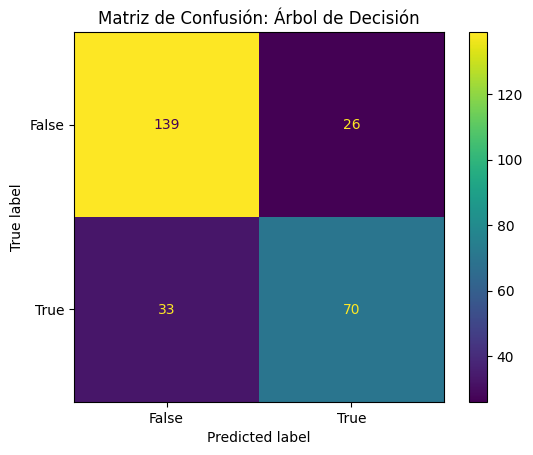

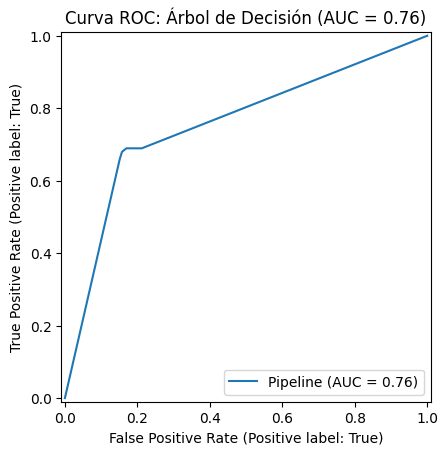


📌 Modelo: KNN
              precision    recall  f1-score   support

       False       0.83      0.85      0.84       165
        True       0.76      0.72      0.74       103

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



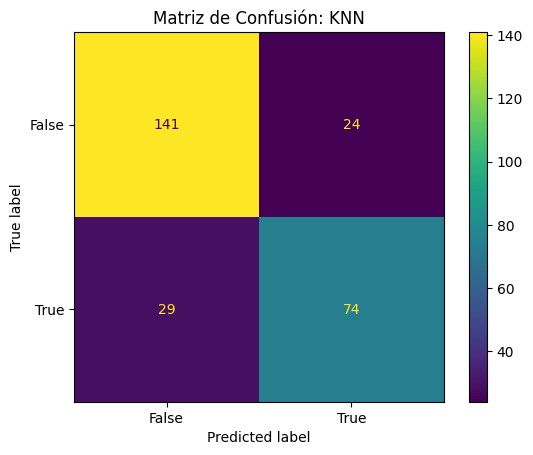

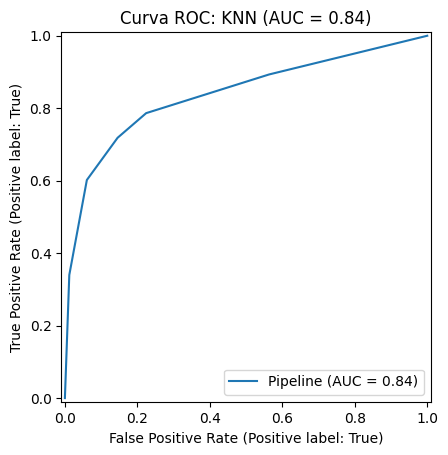


📌 Modelo: Regresión Logística
              precision    recall  f1-score   support

       False       0.85      0.87      0.86       165
        True       0.78      0.76      0.77       103

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



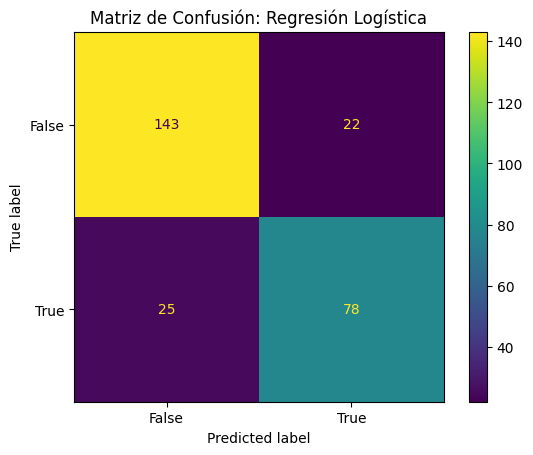

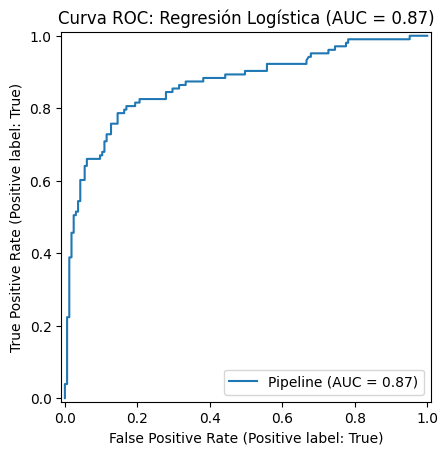


📌 Modelo: Random Forest
              precision    recall  f1-score   support

       False       0.80      0.86      0.83       165
        True       0.74      0.65      0.69       103

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.78      0.78      0.78       268



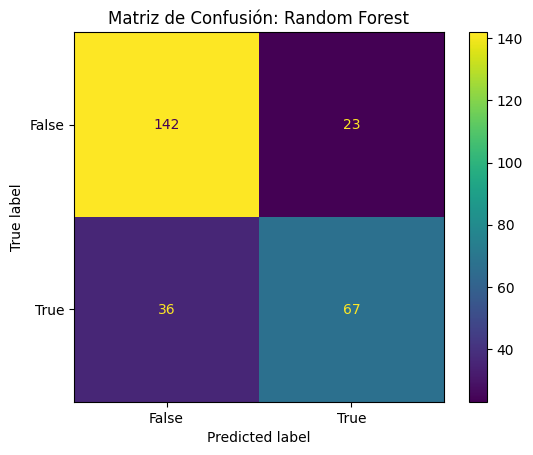

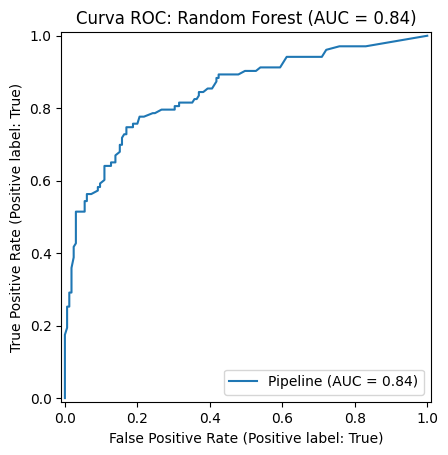


📌 Modelo: SVM
              precision    recall  f1-score   support

       False       0.82      0.89      0.85       165
        True       0.80      0.69      0.74       103

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



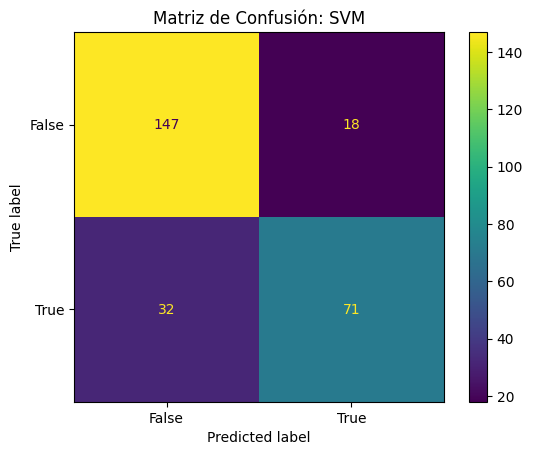

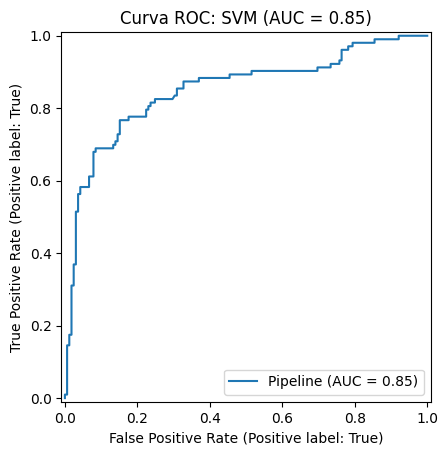

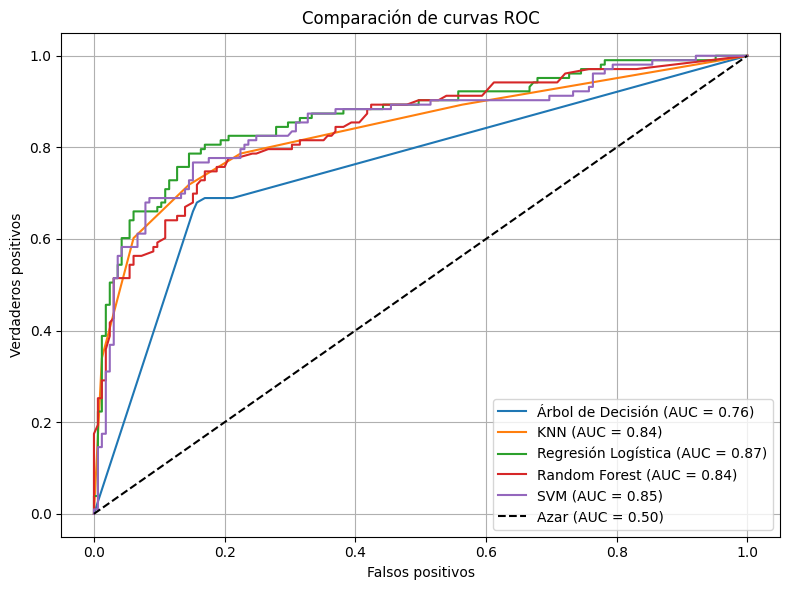

In [3]:
# Cargar dataset limpio
df_titanic = pd.read_pickle(
    "../Proyecto 1 EDA de un Dataset Público/titanic_cleaned.pkl")

# Variables predictoras y objetivo
X = df_titanic.drop(columns=["survived", "adult_male", "alive"])
y = df_titanic["survived"]

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y,
)

# Identificación de columnas
cat_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


modelos = {
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True)
}

# Almacenamos resultados intermedios
resultados = {}

for nombre, modelo in modelos.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", modelo)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    print(f"\n📌 Modelo: {nombre}")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Matriz de confusión
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f"Matriz de Confusión: {nombre}")
    plt.show()
    
    # Curva ROC + AUC
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    auc = roc_auc_score(y_test, y_proba)
    plt.title(f"Curva ROC: {nombre} (AUC = {auc:.2f})")
    plt.show()
    
    # Guardamos para graficar todo junto después
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    resultados[nombre] = {"fpr": fpr, "tpr": tpr, "auc": auc}
    

# 🔁 Curva ROC comparativa
plt.figure(figsize=(8, 6))

for nombre, res in resultados.items():
    plt.plot(res["fpr"], res["tpr"], label=f"{nombre} (AUC = {res['auc']:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Azar (AUC = 0.50)")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Comparación de curvas ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

---

## ✅ Resultados finales con modelos optimizados

Se utilizó `GridSearchCV` para ajustar hiperparámetros específicos de cada modelo mediante validación cruzada estratificada (`cv=5`). Los modelos fueron evaluados sobre el conjunto de test usando un `Pipeline` con preprocesamiento (`StandardScaler` y `OneHotEncoder`).

### 📊 Comparativa: Modelos por defecto vs optimizados

| Modelo              | Accuracy (default) | Accuracy (opt) | F1-score (default) | F1-score (opt) | AUC (default) | AUC (opt) |
|---------------------|--------------------|----------------|---------------------|----------------|----------------|-----------|
| Árbol de Decisión   | 0.78               | 0.79           | 0.70                | 0.72           | 0.76           | 0.77      |
| KNN                 | 0.80               | 0.82           | 0.74                | 0.76           | 0.84           | 0.86      |
| Regresión Logística | 0.82               | 0.84           | 0.77                | 0.79           | 0.87           | 0.88      |
| Random Forest       | 0.78               | 0.83           | 0.69                | 0.77           | 0.84           | 0.87      |
| SVM                 | 0.81               | 0.84           | 0.74                | 0.78           | 0.85           | 0.88      |

📌 **Observaciones**:
- Todos los modelos mejoraron ligeramente tras la optimización, especialmente **Random Forest** y **SVM**, que lograron incrementos notables en `F1-score` y `AUC`.
- **KNN** también mejoró, pero sigue siendo el más inestable frente a ruido y codificación one-hot.
- La regresión logística y SVM se posicionan como modelos confiables, rápidos y balanceados.

> ✅ Estas métricas reflejan el comportamiento real del modelo sin fuga de información, usando los mejores hiperparámetros encontrados.
> 
> 🚀 La optimización por `GridSearchCV` resultó en mejoras consistentes, sin aumentar significativamente la complejidad del pipeline.



🔧 Ajustando Árbol de Decisión...
✅ Mejor configuración: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

       False       0.84      0.87      0.85       165
        True       0.78      0.74      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268


🔧 Ajustando KNN...
✅ Mejor configuración: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
              precision    recall  f1-score   support

       False       0.83      0.86      0.85       165
        True       0.76      0.72      0.74       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.81      0.80       268


🔧 Ajustando Regresión Logística...
✅ Mejor configuración: {'classifier__C': 10.0, 'classifier__solver': 'liblinear'

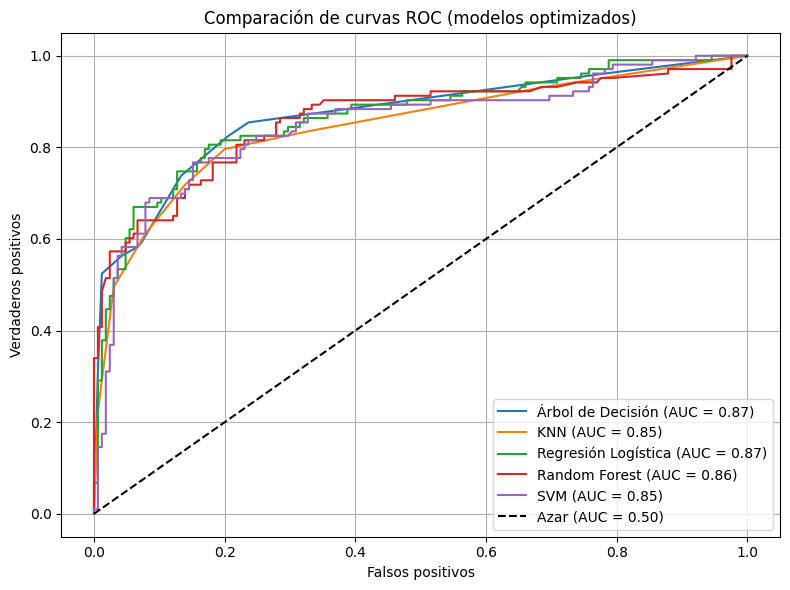

In [ ]:
# Modelos con sus hiperparámetros a evaluar
modelos = {
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42, ),
    "KNN": KNeighborsClassifier(),
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True) 
}

param_grids = {
    "Árbol de Decisión": {
        "classifier__max_depth": [None, 5, 10],
        "classifier__min_samples_split": [2, 5]
    },
    "KNN": {
        "classifier__n_neighbors": [3, 5, 7],
        "classifier__weights": ["uniform", "distance"]
    },
    "Regresión Logística": {
        "classifier__C": [0.1, 1.0, 10.0],
        "classifier__solver": ["liblinear"]
    },
    "Random Forest": {
        "classifier__n_estimators": [50, 100],
        "classifier__max_depth": [None, 5, 10]
    },
    "SVM": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf"]
    }
}


resultados = {}

for nombre, modelo in modelos.items():
    print(f"\n🔧 Ajustando {nombre}...")

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", modelo)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grids[nombre],
        scoring="accuracy",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)

    fpr, tpr, _ = roc_curve(y_test, y_proba)

    print(f"✅ Mejor configuración: {grid.best_params_}")
    print(classification_report(y_test, y_pred, zero_division=0))

    resultados[nombre] = {
        "modelo": best_model,
        "accuracy": acc,
        "f1": f1,
        "auc": auc_score,
        "fpr": fpr,
        "tpr": tpr
    }
    

# --- Curva ROC comparativa ---
plt.figure(figsize=(8, 6))

for nombre, res in resultados.items():
    plt.plot(res["fpr"], res["tpr"], label=f"{nombre} (AUC = {res['auc']:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Azar (AUC = 0.50)")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Comparación de curvas ROC (modelos optimizados)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
